In [1]:
# Just testing my Spatial AE

import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision

from torch.utils.data import TensorDataset, DataLoader, random_split

#from tqdm.autonotebook import tqdm, trange

from utils.models import *
from utils.model_tools import *
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

!pwd

Using cuda:1 device
/home/mag/predictive-coding-thesis/src


In [3]:
torch.manual_seed(321)

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
])

data_dir = 'data/detached'

dataset = HeadingDataset(source_directory=data_dir,
                                 transform=transform)

train_ratio = math.floor(len(dataset) * 0.9)
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{len(train_data)} training samples')

batch_size = 16
# does it matter in this instance if you shuffle? I think you can get away with it
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

87891 training samples


In [4]:
latent_model_file = 'model_files/continous_detach_87891_samples-60ep.pth'
latent_model = PredictiveCoderWithHead()
latent_model.to(device)
latent_model.load_state_dict(torch.load(latent_model_file)['state_dict'])#, map_location=torch.device(device)))
latent_model.eval()
for param in latent_model.parameters():
    param.requires_grad = False
    

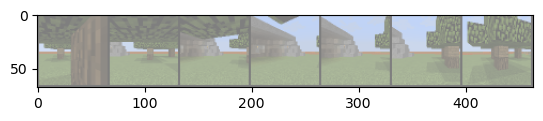

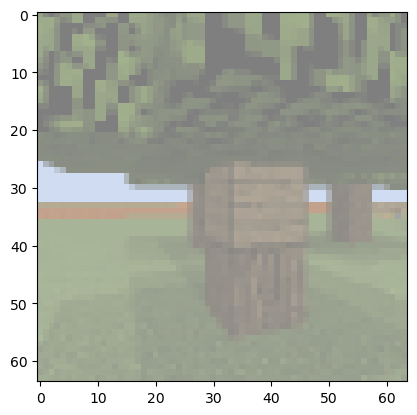

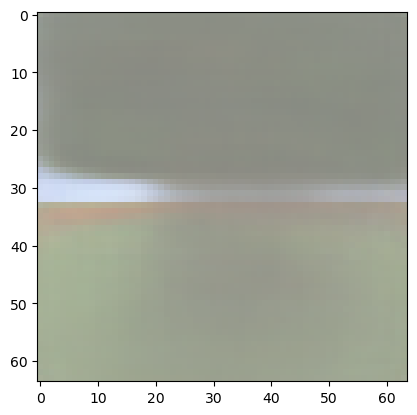

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

seq, corr = next(iter(train_loader))
#img = next(iter(train_loader))
frames, headings = seq

imshow(torchvision.utils.make_grid(frames[0]))
imshow(corr[0])
#imshow(img[0])

with torch.no_grad():
    pred = latent_model(frames.to(device), headings.to(device)) 

imshow(pred[0])


### Testing the spatial maps

In [4]:
data = np.load('data/face-forward/coords_random_faceforward_2024-01-09-17-09-17.npy')

print(np.max(data[:,0]))
print(np.min(data[:,0]))
print(np.max(data[:,1]))
print(np.min(data[:,1]))

-424.5
-487.5
-654.5
-692.5


In [6]:
from torch.utils.data._utils.collate import default_collate

def normalize_coords(batch):
    """
    Custom collate function that normalizes the target values in a batch.
    Assumes each element in batch is a tuple (features, target) and target is a tensor of shape (2,)
    with target[0] as x and target[1] as y.
    """

    # Separate features and targets
    features, targets = zip(*batch)

    # Convert lists to PyTorch tensors using default collate
    features = default_collate(features)
    targets = default_collate(targets)

    # Normalize targets
    x_min, x_max = -487.5, -424.5
    y_min, y_max = -692.5, -654.5

    targets[..., 0] = (targets[..., 0] - x_min) / (x_max - x_min)  # Normalize x
    targets[..., 1] = (targets[..., 1] - y_min) / (y_max - y_min)  # Normalize y

    return features, targets[:, :-1]
    

In [7]:
# Load in the coordinate data
data_dir = 'data/continuous'

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
])

dataset = CoordinateDataset(source_directory=data_dir, transform=transform)

train_ratio = math.floor(len(dataset) * 0.9)
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{train_ratio} training samples')
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=normalize_coords)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=normalize_coords)

['coords_random_faceforward_2024-03-13-00-38-51.npy', 'coords_random_faceforward_2024-03-13-00-42-12.npy', 'coords_random_faceforward_2024-03-13-00-45-40.npy', 'coords_random_faceforward_2024-03-13-00-49-03.npy', 'coords_random_faceforward_2024-03-13-00-52-25.npy', 'coords_random_faceforward_2024-03-13-00-55-47.npy', 'coords_random_faceforward_2024-03-13-00-59-09.npy', 'coords_random_faceforward_2024-03-13-01-02-31.npy', 'coords_random_faceforward_2024-03-13-01-05-53.npy', 'coords_random_faceforward_2024-03-13-01-09-37.npy', 'coords_random_faceforward_2024-03-13-01-12-59.npy', 'coords_random_faceforward_2024-03-13-01-16-21.npy', 'coords_random_faceforward_2024-03-13-01-21-10.npy', 'coords_random_faceforward_2024-03-13-01-24-32.npy', 'coords_random_faceforward_2024-03-13-01-27-55.npy', 'coords_random_faceforward_2024-03-13-01-31-25.npy', 'coords_random_faceforward_2024-03-13-01-34-47.npy', 'coords_random_faceforward_2024-03-13-01-38-09.npy', 'coords_random_faceforward_2024-03-13-01-41-3

In [8]:
def denormalize_targets(normalized_target):
    """
    Denormalizes the target values from the range [0, 1] back to their original scale.
    Assumes normalized_target is a tensor of shape (..., 2) where normalized_target[..., 0] is x and normalized_target[..., 1] is y.
    """
    # Define the min and max values for x and y
    x_min, x_max = -487.5, -424.5
    y_min, y_max = -692.5, -654.5

    # Denormalize x
    x_denormalized = normalized_target[..., 0] * (x_max - x_min) + x_min
    
    # Denormalize y
    y_denormalized = normalized_target[..., 1] * (y_max - y_min) + y_min

    # Combine and return
    return torch.stack([x_denormalized, y_denormalized], dim=-1)


torch.Size([16, 3, 64, 64]) torch.Size([16, 2])


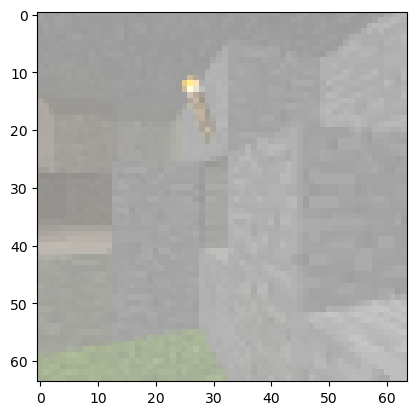

tensor([0.1530, 0.3512])
tensor([-477.8609, -679.1556])


In [9]:
# Sample of coord dataset:

x, y = next(iter(test_loader))
print(x.shape, y.shape)

imshow(x[0])
print(y[0])
print(denormalize_targets(y[0]))

In [10]:
# Set up the model, which takes as input my trained predictive coder encoder and attn
device = 'cuda' if torch.cuda.is_available() else "cpu"

loc_predictor_file = latent_model_file[:-3] + '_predictor.pt'

print(loc_predictor_file)

model = LocationPredictor(latent_model, input_dim=128, hidden_dim=250)
model.to(device)

num_epochs = 10
steps_per_epoch = len(train_loader)

learning_rate = 0.01
weight_decay = 0.0001

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)


model_files/continous_detach_87891_samples-60ep._predictor.pt


In [11]:
model.eval()
with torch.no_grad():
    pred = model(x.to(device))


print(denormalize_targets(pred))
print(denormalize_targets(y))

tensor([[-479.3060, -685.5053],
        [-484.4811, -686.7148],
        [-481.5479, -682.0583],
        [-474.8483, -688.1201],
        [-481.3780, -686.4113],
        [-480.0468, -686.1746],
        [-473.9231, -680.7127],
        [-479.2391, -683.7007],
        [-477.6721, -674.6599],
        [-477.6627, -680.4149],
        [-477.5031, -680.9181],
        [-472.5503, -686.7986],
        [-470.9223, -688.2145],
        [-477.7466, -682.7686],
        [-479.4576, -688.5064],
        [-471.0696, -685.9440]], device='cuda:0')
tensor([[-477.8609, -679.1556],
        [-433.5618, -673.1249],
        [-478.2294, -671.0395],
        [-438.7015, -674.9326],
        [-431.6727, -671.2736],
        [-478.0406, -661.2341],
        [-439.7782, -657.6547],
        [-482.7213, -668.5762],
        [-453.7094, -682.8458],
        [-467.7654, -665.3735],
        [-473.5423, -677.3471],
        [-424.7051, -680.8008],
        [-477.4300, -657.5721],
        [-456.8433, -682.3253],
        [-479.1178, -6

In [12]:
train_losses_file = 'logs/pred-loc-detach-train-200-ep-5ep.txt'
test_losses_file = 'logs/pred-loc-detach-test-200-ep-5ep.txt'


train_losses = []
test_losses = []
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train(train_loader, model, loss_fn, optimizer, device)
        test_loss = test(test_loader, model, loss_fn, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        torch.save(model.state_dict(), loc_predictor_file)

finally:
    torch.save(model.state_dict(), loc_predictor_file)
    
    with open(train_losses_file, 'w') as fp:
        for s in train_losses:
            fp.write("%s\n" % s)
            
    with open(test_losses_file, 'w') as fp:
        for x in test_losses:
            fp.write("%s\n" % x)
    
    print("Done!")


Epoch 1
-------------------------------
loss: 0.183356  [    0/84600]
loss: 0.063184  [16000/84600]
loss: 0.070821  [32000/84600]
loss: 0.073770  [48000/84600]
loss: 0.058972  [64000/84600]
loss: 0.057406  [80000/84600]
Test Error: 
 Avg loss: 0.052413 

Epoch 2
-------------------------------
loss: 0.088001  [    0/84600]
loss: 0.039878  [16000/84600]
loss: 0.058373  [32000/84600]
loss: 0.064120  [48000/84600]
loss: 0.050981  [64000/84600]
loss: 0.048005  [80000/84600]
Test Error: 
 Avg loss: 0.048472 

Epoch 3
-------------------------------
loss: 0.021184  [    0/84600]
loss: 0.074875  [16000/84600]
loss: 0.070844  [32000/84600]
loss: 0.033947  [48000/84600]
loss: 0.044638  [64000/84600]
loss: 0.074819  [80000/84600]
Test Error: 
 Avg loss: 0.045524 

Epoch 4
-------------------------------
loss: 0.036612  [    0/84600]
loss: 0.046130  [16000/84600]
loss: 0.043000  [32000/84600]
loss: 0.048962  [48000/84600]
loss: 0.050581  [64000/84600]
loss: 0.037595  [80000/84600]
Test Error: 
 A

KeyboardInterrupt: 

In [13]:
import torch
from collections import defaultdict

model

model.eval()  # Set the model to evaluation mode

# Dictionary to store sum of predictions and count for each actual location
predictions_sum = defaultdict(lambda: [torch.zeros(2), 0])

with torch.no_grad():  # Disable gradient computation
    for frames, actual_locations in test_loader:
        frames, actual_locations = frames.to(device), actual_locations.to(device)
        # Pass the features through the model to get predictions
        predictions = model(frames)

        # Iterate through the batch and update the predictions_sum dictionary
        for actual, pred in zip(actual_locations, predictions):
            denorm_actual = denormalize_targets(actual.cpu())
            actual = tuple(denorm_actual.numpy())  # Convert to a tuple for dictionary key
            predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
            predictions_sum[actual][1] += 1  # Count

    for frames, actual_locations in train_loader:
        frames, actual_locations = frames.to(device), actual_locations.to(device)
        # Pass the features through the model to get predictions
        predictions = model(frames)

        # Iterate through the batch and update the predictions_sum dictionary
        for actual, pred in zip(actual_locations, predictions):
            denorm_actual = denormalize_targets(actual.cpu())
            actual = tuple(denorm_actual.numpy())  # Convert to a tuple for dictionary key
            predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
            predictions_sum[actual][1] += 1  # Count
            
# Calculate the average predicted location for each actual location
average_predictions = {actual: denormalize_targets(sum_pred[0] / sum_pred[1]) for actual, sum_pred in predictions_sum.items()}

# Example: Print the average predicted location for each actual location
#for actual_location, average_pred in average_predictions.items():
#    print(f"Actual Location: {actual_location}, Average Predicted Location: {average_pred.numpy()}")



In [15]:
import pickle 

f = open("logs/detached-locs.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(average_predictions,f)

# close file
f.close()

In [16]:
average_predictions = np.load("logs/continuous-locs.pkl", allow_pickle=True)

# Make the added noise model
std = 1
added_noise = []

for pos in average_predictions.keys():
    noise = np.random.normal(0, std)
    added_noise.append([pos[0] + noise, pos[1] + noise])

noisy_np = np.stack(added_noise, axis=0)
base_np = np.stack(list(average_predictions.keys()))
print(base_np.shape)
data_noise_model = np.linalg.norm(noisy_np - base_np, axis=1)

# Make the autoencoder model
#autoencode_values = np.stack([pos for pos in average_predictions.values()], axis=0)
#data_auto_encoding = np.linalg.norm(autoencode_values - base_np, axis=1)

# Make the predictive coding model (face north)
#pred_average_predictions = np.load('logs/actual_locs.pkl', allow_pickle=True)
predictive_values = np.stack([pos for pos in average_predictions.values()], axis=0)
data_predictive_coding = np.linalg.norm(predictive_values - base_np, axis=1)

# Make the shuffle model
shuffled = base_np.copy()
np.random.shuffle(shuffled)
print(shuffled.shape)
data_random_pairs = np.linalg.norm(shuffled - base_np, axis=1)


(93972, 2)
(93972, 2)


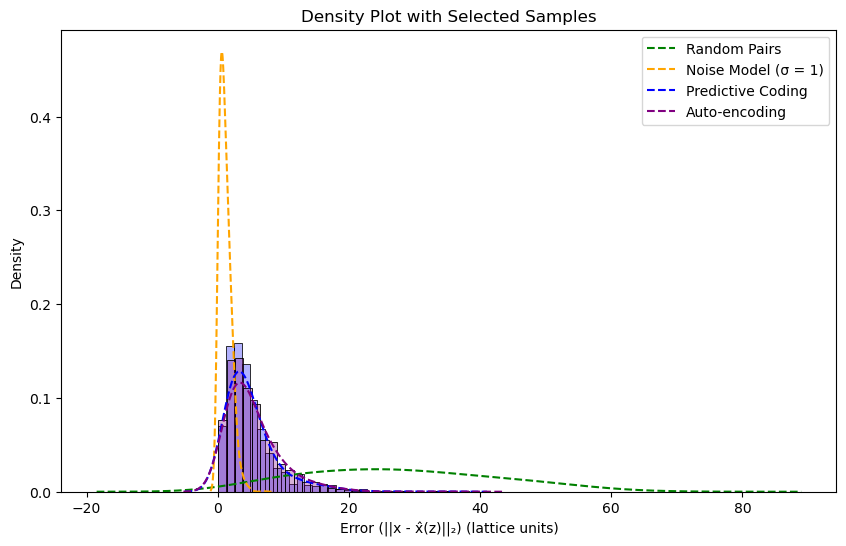

In [106]:
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plotting KDE for all distributions
sns.kdeplot(data_random_pairs, bw_adjust=2, label="Random Pairs", color="green", linestyle="--")
sns.kdeplot(data_noise_model, bw_adjust=2, label="Noise Model (σ = 1)", color="orange", linestyle="--")
sns.kdeplot(data_predictive_coding, bw_adjust=2, label="Predictive Coding", color="blue", linestyle="--")
sns.kdeplot(data_auto_encoding, bw_adjust=2, label="Auto-encoding", color="purple", linestyle="--")

# Plotting histograms only for predictive coding and auto-encoding with normalization
sns.histplot(data_predictive_coding, kde=False, color="blue", alpha=0.3, bins=30, stat="density")
sns.histplot(data_auto_encoding, kde=False, color="purple", alpha=0.3, bins=30, stat="density")

# Additional plot formatting to match the user's request
plt.title('Density Plot with Selected Samples')
plt.xlabel('Error (||x - x̂(z)||₂) (lattice units)')
plt.ylabel('Density')
plt.legend()
plt.show()

# 0.0010 density random pairs
# noise model 0.025 top density
# 0.0010 density pred code

In [ ]:
# perspective structure and invariant structure
# 1st used in dead reckoning
# 2nd is object to object structure (blind people can do this)
# Connection with SLAM
# there is a simple visual slam -- take a look here
# visual odometry
# rat SLAM
# head direction is visual input purely

## Thresholding Activations

In [ ]:

x_min, x_max = -487.5, -424.5
z_min, z_max = -692.5, -654.5


all_latents = []

with torch.no_grad():
     for seq, pred in loader:
for x in np.linspace(x_min, x_max, num=x_max - x_min): 
    for y in np.linspace(z_min, z_max, num=z_max - z_min):
        latents = get_latent_values(x, y)
        all_latents.append(latents)

all_latents = np.array(all_latents)  # Convert to a numpy array for efficient processing

# Calculate the 90th percentile for each latent variable
percentiles = np.percentile(all_latents, 90, axis=0)

# Function to apply threshold to latent values at a given x, y location
def threshold_latents(x, y, percentiles):
    latents = get_latent_values(x, y)
    binary_response = (latents >= percentiles).astype(int)
    return binary_response

# Example usage
x, y = 0, 0  # Example location
binary_response = threshold_latents(x, y, percentiles)
print(binary_response)  # This will print the binary (0 or 1) response for each latent at location (x, y)
